# Голумин Никита РТ5-61Б

# Прогнозирование шансов поступления в аспирантуру

В данном проекте мы будем использовать набор данных о поступлении в аспирантуру в Индии, доступный по ссылке: [Kaggle Graduate Admissions Dataset](https://www.kaggle.com/datasets/mohansacharya/graduate-admissions?resource=download)

Этот проект может помочь выпускникам оценить свои шансы на поступление и выявить ключевые факторы, влияющие на этот процесс.

## Описание датасета

Датасет включает один файл `Admission_Predict.csv` с такими колонками:

- **GRE Scores (из 340)**: результат теста GRE
- **TOEFL Scores (из 120)**: результат теста TOEFL
- **University Rating (из 5)**: рейтинг университета
- **Statement of Purpose (из 5)**: оценка мотивационного письма
- **Undergraduate GPA (из 10)**: средний балл за бакалавриат
- **Research Experience (0 или 1)**: наличие исследовательского опыта
- **Chance of Admit (от 0 до 1)**: вероятность поступления

## Цель задачи

Цель данной задачи регрессии — предсказать вероятность поступления (`Chance of Admit`) на основе предоставленных признаков.


### Импорт библиотек

In [3]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from sklearn.metrics import confusion_matrix
# from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score 
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.svm import SVC, NuSVC, LinearSVC, OneClassSVM, SVR, NuSVR, LinearSVR
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.ensemble import ExtraTreesClassifier, ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
%matplotlib inline 
sns.set(style="ticks")

### Загрузка данных
Загрузим файлы датасета в помощью библиотеки Pandas.

In [4]:
data = pd.read_csv('data/Admission_Predict.csv')

In [5]:
# Удалим дубликаты записей, если они присутствуют
data = data.drop_duplicates()

### Проведение разведочного анализа данных. Построение графиков, необходимых для понимания структуры данных. Анализ и заполнение пропусков в данных.

- **Основные характеристики датасета**

In [6]:
# Первые 5 строк датасета
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit
0,1,337,118,4,4.5,4.5,9.65,1,0.92
1,2,324,107,4,4.0,4.5,8.87,1,0.76
2,3,316,104,3,3.0,3.5,8.00,1,0.72
3,4,322,110,3,3.5,2.5,8.67,1,0.80
4,5,314,103,2,2.0,3.0,8.21,0,0.65


In [7]:
# Размер  датасета - 400 строк, 9 колонок
data.shape

(400, 9)

In [8]:
# Список колонок
data.columns

Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit '],
      dtype='object')

In [9]:
# Список колонок с типами данных 
data.dtypes

Serial No.             int64
GRE Score              int64
TOEFL Score            int64
University Rating      int64
SOP                  float64
LOR                  float64
CGPA                 float64
Research               int64
Chance of Admit      float64
dtype: object

In [10]:
# Проверим наличие пустых значений
data.isnull().sum()

Serial No.           0
GRE Score            0
TOEFL Score          0
University Rating    0
SOP                  0
LOR                  0
CGPA                 0
Research             0
Chance of Admit      0
dtype: int64

**Вывод**: представленный набор данных не содержит пропусков.



- **Построение графиков для понимания структуры данных**

D:\Anaconda\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


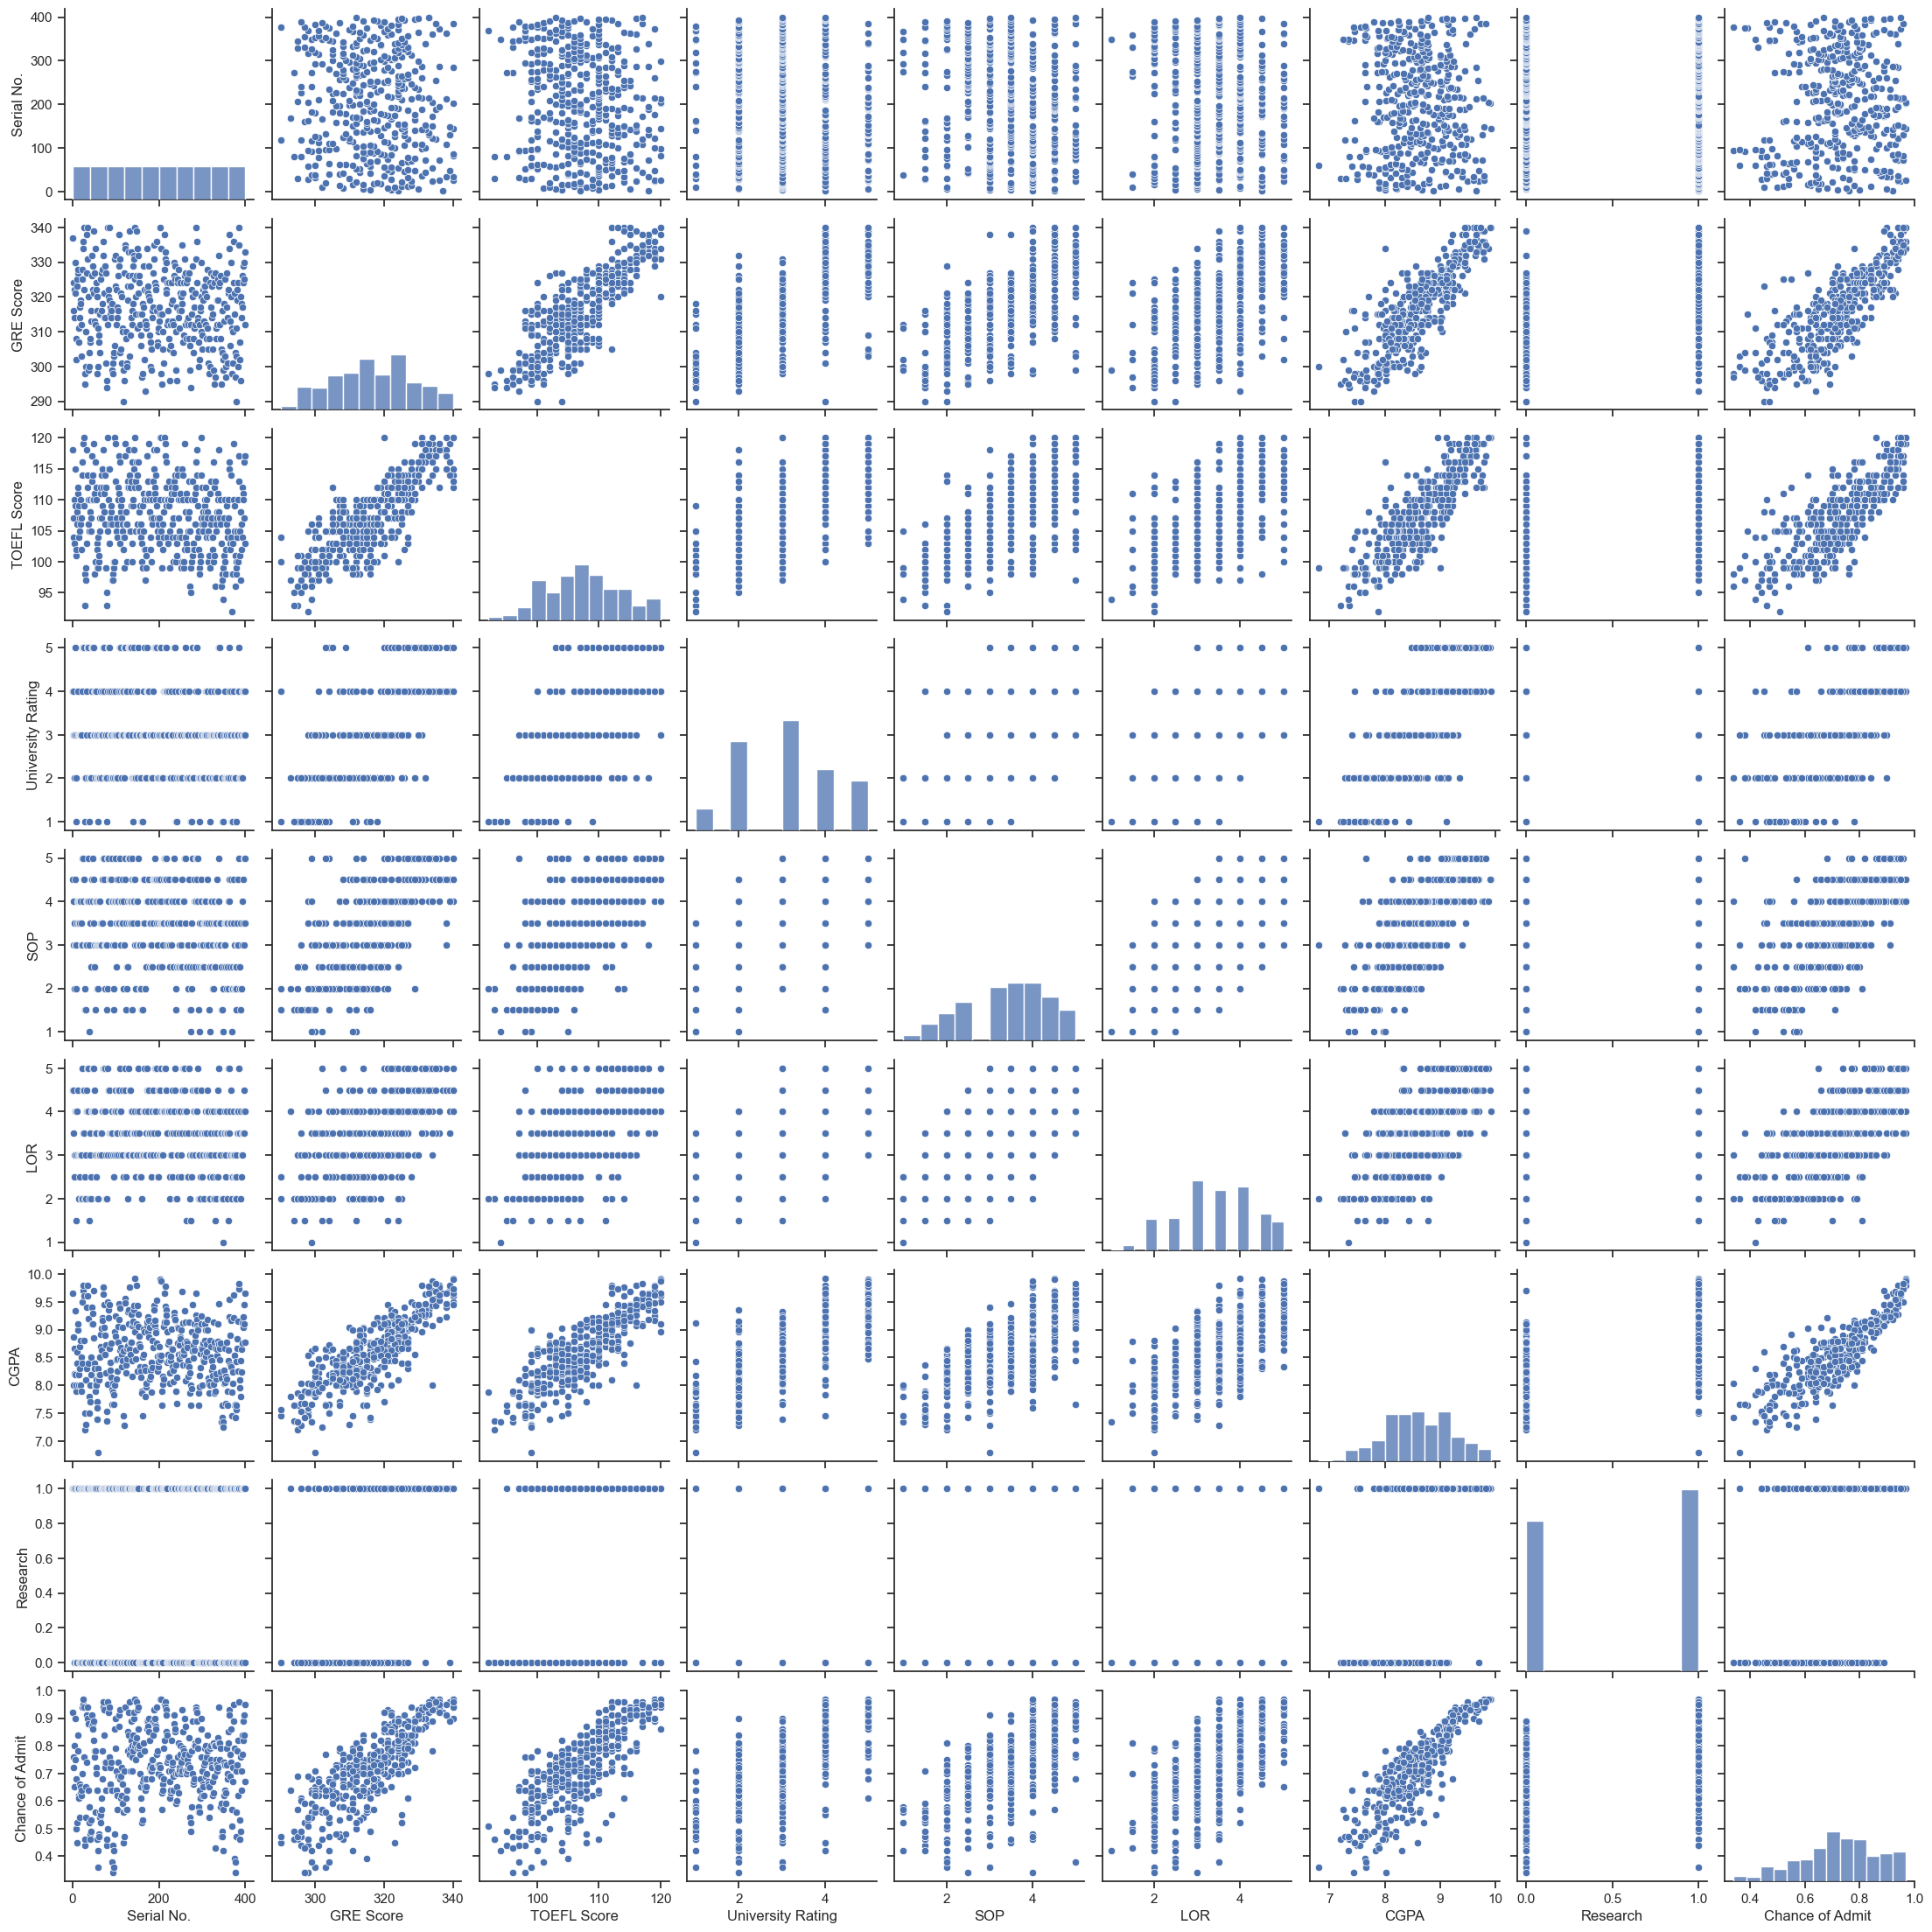

In [11]:
# Парные диаграммы
sns.pairplot(data)

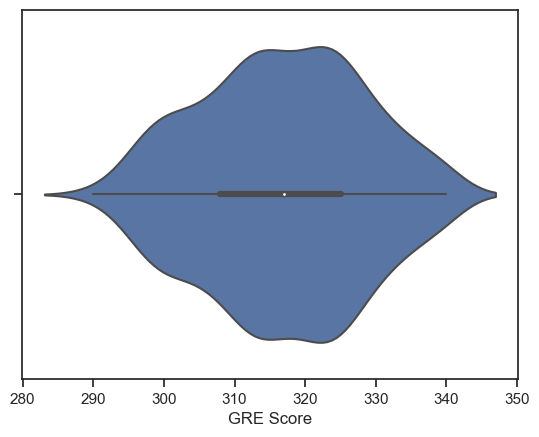

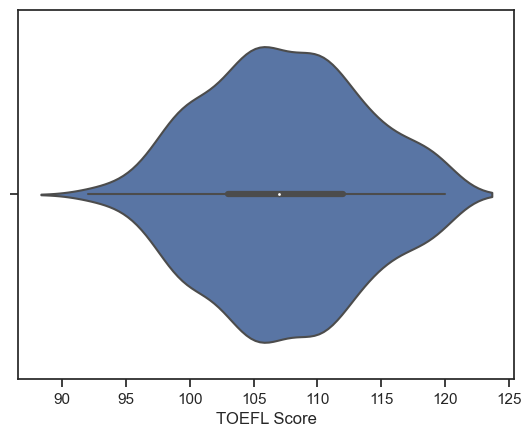

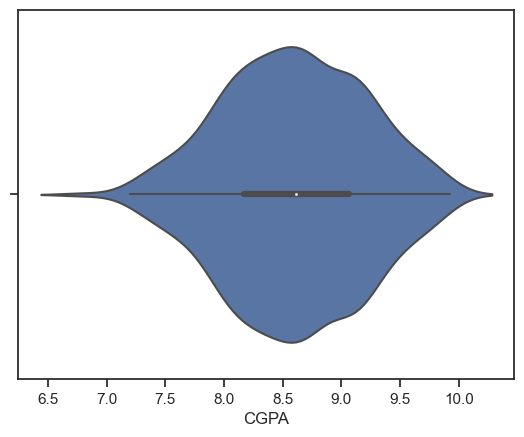

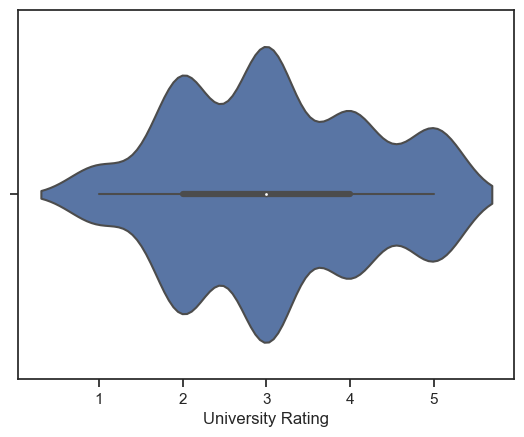

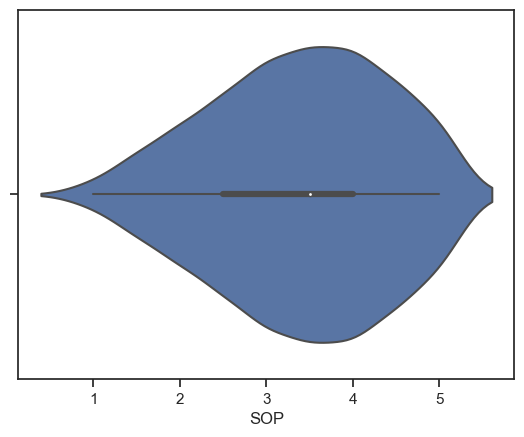

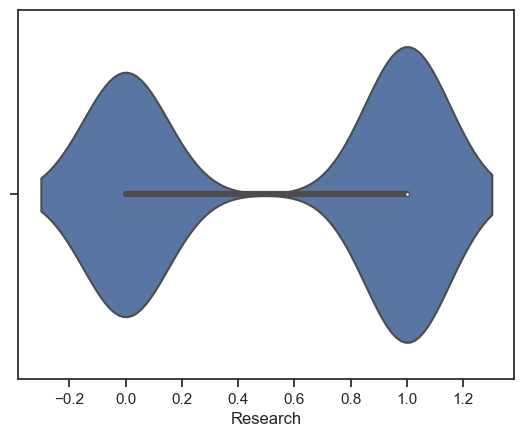

In [13]:
# Скрипичные диаграммы для числовых колонок
for col in ['GRE Score', 'TOEFL Score', 'CGPA', 'University Rating', 'SOP', 'Research']:
    sns.violinplot(x=data[col])
    plt.show()

### Выбор признаков, подходящих для построения моделей. Кодирование категориальных признаков. Масштабирование данных. Формирование вспомогательных признаков, улучшающих качество моделей

Для построения моделей будем использовать все признаки кроме признака Serial No., потому что он определяет только порядковй номер.

Категориальные признаки присутствуют,однако их кодирования не требуется.

Вспомогательные признаки для улучшения качества моделей в данном примере мы строить не будем.
Выполним масштабирование данных. 

In [14]:
# Числовые колонки для масштабирования
scale_cols = ['TOEFL Score', 'CGPA', 'University Rating', 'SOP', 'Research', 'LOR ']

In [15]:
sc1 = MinMaxScaler()
sc1_data = sc1.fit_transform(data[scale_cols])

In [16]:

scaled_data = np.log1p(data['GRE Score'])


In [17]:
# Добавим масштабированные данные в набор данных
for i in range(len(scale_cols)):
    col = scale_cols[i]
    new_col_name = col + '_scaled'
    data[new_col_name] = sc1_data[:,i]
data['GRE Score_scaled'] = scaled_data

In [18]:
data.head()

,Serial No.,GRE Score,TOEFL Score,University Rating,SOP,LOR,CGPA,Research,Chance of Admit,TOEFL Score_scaled,CGPA_scaled,University Rating_scaled,SOP_scaled,Research_scaled,LOR _scaled,GRE Score_scaled
0,1,337,118,4,4.5,4.5,9.65,1,0.92,0.928571,0.913462,0.75,0.875,1.0,0.875,5.823046
1,2,324,107,4,4.0,4.5,8.87,1,0.76,0.535714,0.663462,0.75,0.750,1.0,0.875,5.783825
2,3,316,104,3,3.0,3.5,8.00,1,0.72,0.428571,0.384615,0.50,0.500,1.0,0.625,5.758902
3,4,322,110,3,3.5,2.5,8.67,1,0.80,0.642857,0.599359,0.50,0.625,1.0,0.375,5.777652
4,5,314,103,2,2.0,3.0,8.21,0,0.65,0.392857,0.451923,0.25,0.250,0.0,0.500,5.752573


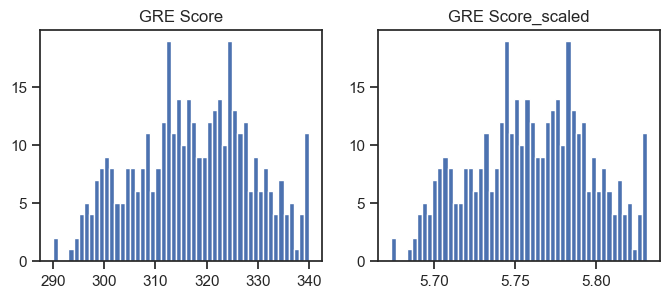

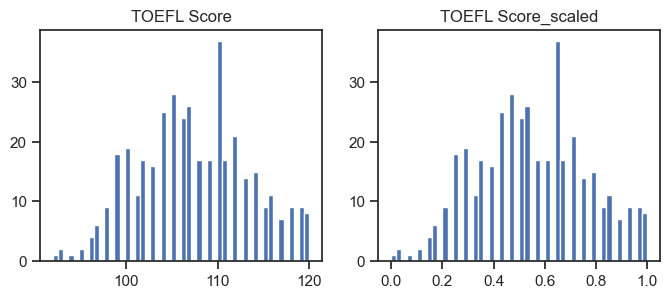

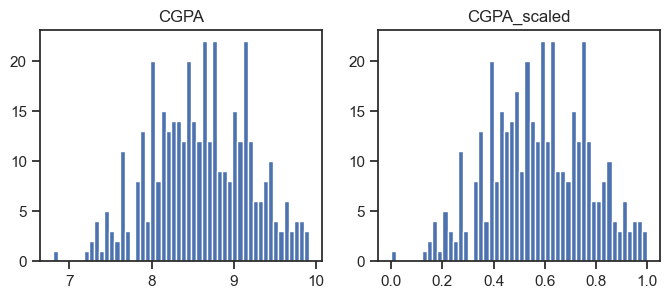

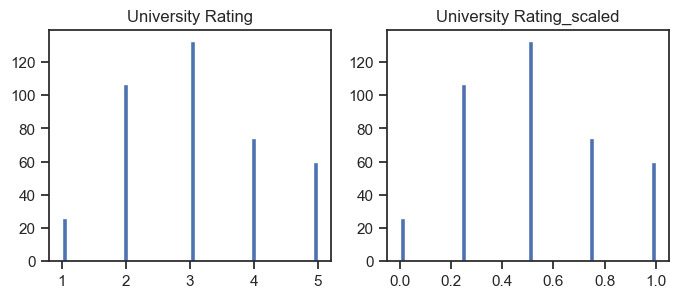

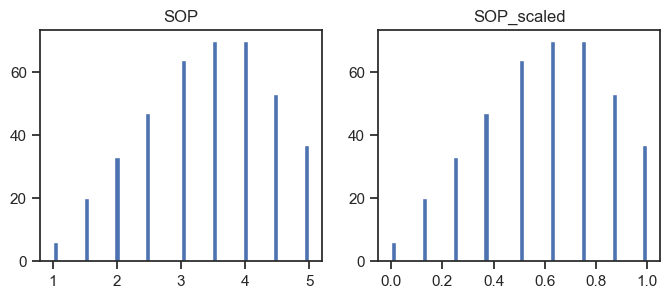

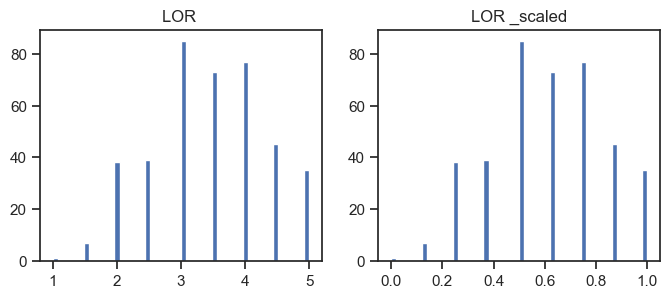

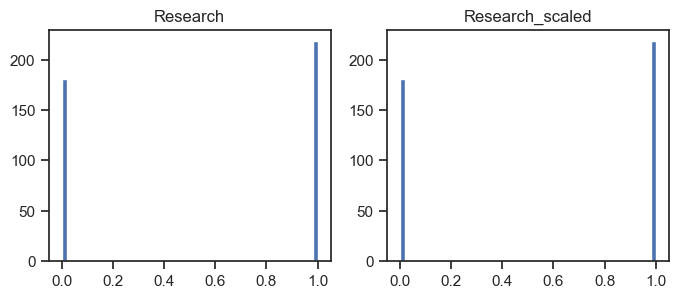

In [19]:
# Проверим, что масштабирование не повлияло на распределение данных
scale_cols = ['GRE Score','TOEFL Score', 'CGPA', 'University Rating', 'SOP', 'LOR ', 'Research']
for col in scale_cols:
    col_scaled = col + '_scaled'

    fig, ax = plt.subplots(1, 2, figsize=(8,3))
    ax[0].hist(data[col], 50)
    ax[1].hist(data[col_scaled], 50)
    ax[0].title.set_text(col)
    ax[1].title.set_text(col_scaled)
    plt.show()

### Проведение корреляционного анализа данных. Формирование промежуточных выводов о возможности построения моделей машинного обучения.

In [20]:
print(data.columns)


Index(['Serial No.', 'GRE Score', 'TOEFL Score', 'University Rating', 'SOP',
       'LOR ', 'CGPA', 'Research', 'Chance of Admit ', 'TOEFL Score_scaled',
       'CGPA_scaled', 'University Rating_scaled', 'SOP_scaled',
       'Research_scaled', 'LOR _scaled', 'GRE Score_scaled'],
      dtype='object')


In [21]:
corr_cols_1 = scale_cols + ['Chance of Admit ']
corr_cols_1

['GRE Score',
 'TOEFL Score',
 'CGPA',
 'University Rating',
 'SOP',
 'LOR ',
 'Research',
 'Chance of Admit ']

In [22]:
scale_cols_postfix = [x+'_scaled' for x in scale_cols]
corr_cols_2 = scale_cols_postfix + ['Chance of Admit ']
corr_cols_2

['GRE Score_scaled',
 'TOEFL Score_scaled',
 'CGPA_scaled',
 'University Rating_scaled',
 'SOP_scaled',
 'LOR _scaled',
 'Research_scaled',
 'Chance of Admit ']

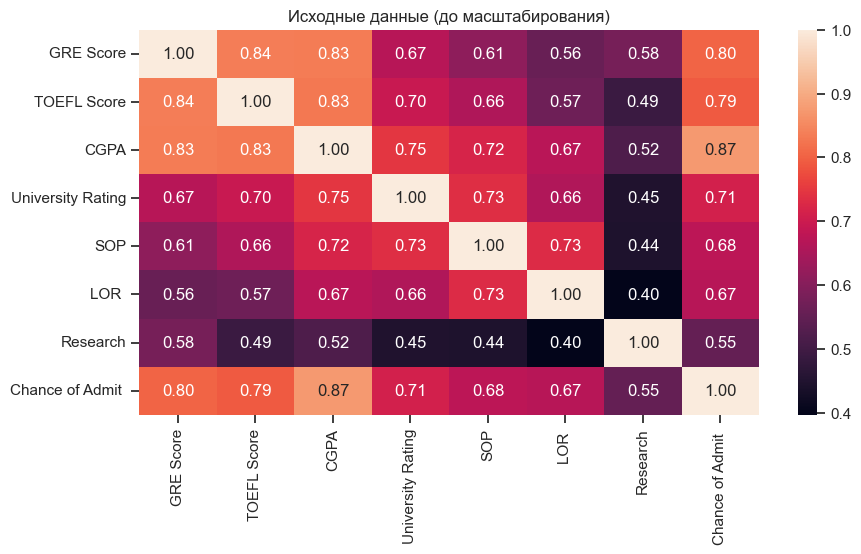

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_1].corr(), annot=True, fmt='.2f')
ax.set_title('Исходные данные (до масштабирования)')
plt.show()

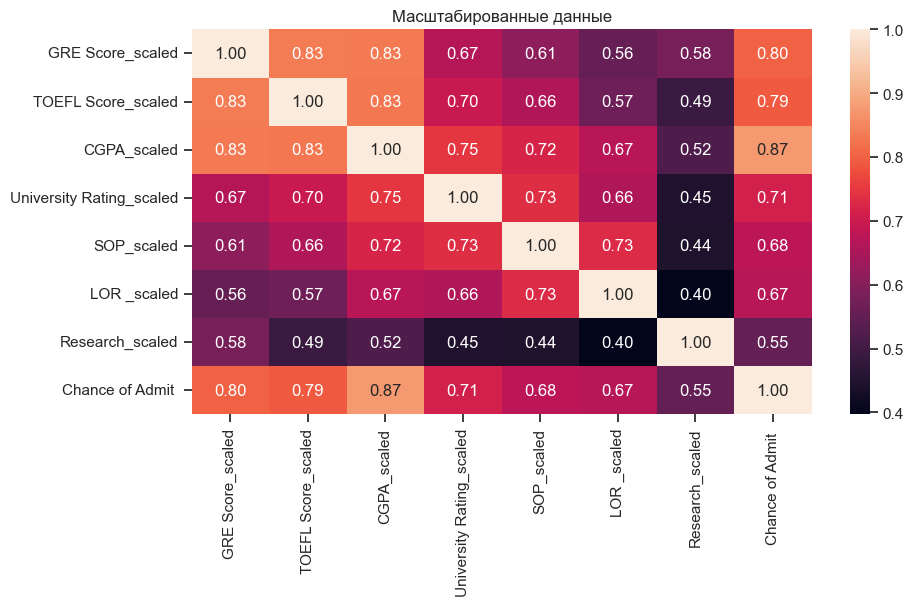

In [23]:
fig, ax = plt.subplots(figsize=(10,5))
sns.heatmap(data[corr_cols_2].corr(), annot=True, fmt='.2f')
ax.set_title('Масштабированные данные')
plt.show()


#### На основе корреляционной матрицы можно сделать следующие выводы:

- Корреляционные матрицы для исходных и масштабированных данных совпадают.
- Целевой признак классификации "Chance of Admit" наиболее сильно коррелирует с средним баллом бакалавра (0.87), баллом  TOEFL (0,79) и выпускным баллом (0.79). Однако между этими тремя признаками есть сильная корреляция, поэтому возьмем только признак "GRE Score", так как он имеет самую большую корреляцию. Также возьмем признак "University Rating" (0.71)
- Большие по модулю значения коэффициентов корреляции свидетельствуют о значимой корреляции между исходными признаками и целевым признаком. На основании корреляционной матрицы можно сделать вывод о том, что данные позволяют построить модель машинного обучения.

### Выбор метрик для последующей оценки качества моделей:
- Mean absolute error - средняя абсолютная ошибка
- Mean squared error - средняя квадратичная ошибка
- R2 - коэффициент детерминации

**MAE** и **MSE** взяты как как важна направленность ошибки, **R2** так как важно, насколько хорошо модель объясняет вариацию в данных

MAE и MSE взяты как как важна направленность ошибки, R2 так как важно, насколько хорошо модель объясняет вариацию в данных

### Выбор моделей:
- Линейная регрессия
- Метод ближайших соседей
- Методопорных векторов
- Решающее дерево
- Случайный лес
- Градиентный бустинг

In [24]:
# На основе масштабированных данных выделим обучающую и тестовую выборки
# Создаем словарь с ключами и значениями для DataFrame
data_dict = {"GRE Score_scaled": data['GRE Score_scaled'], "University Rating_scaled": data['University Rating_scaled']}

# Создаем DataFrame из словаря
df_scaled = pd.DataFrame(data_dict)

# Теперь, когда у нас есть DataFrame с масштабированными данными, мы можем разделить его на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(df_scaled, data['Chance of Admit '], random_state=1)


In [25]:
#размеры выборок
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((300, 2), (300,), (100, 2), (100,))

### Построение базового решения (baseline) для выбранных моделей без подбора гиперпараметров. Производится обучение моделей на основе обучающей выборки и оценка качества моделей на основе тестовой выборки.


In [26]:
# Модели
regr_models = {'LR': LinearRegression(), 
               'KNN_5':KNeighborsRegressor(n_neighbors=5),
               'SVR':SVR(),
               'Tree':DecisionTreeRegressor(),
               'RF':RandomForestRegressor(),
               'GB':GradientBoostingRegressor()}

In [27]:
# from torchmetrics import MetricLogger
# # Сохранение метрик
# regrMetricLogger = MetricLogger()
regrMetricLogger = pd.DataFrame(columns=['ModelName', 'MetricName', 'Value'])


In [28]:
def regr_train_model(model_name, model, regrMetricLogger):
    model.fit(X_train, y_train)
    Y_pred = model.predict(X_test)
    
    mae = mean_absolute_error(y_test, Y_pred)
    mse = mean_squared_error(y_test, Y_pred)
    r2 = r2_score(y_test, Y_pred)

    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'MAE', mae]
    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'MSE', mse]
    regrMetricLogger.loc[len(regrMetricLogger)] = [model_name, 'R2', r2]
   
    print('{} \t MAE={}, MSE={}, R2={}'.format(
        model_name, round(mae, 3), round(mse, 3), round(r2, 3)))

In [29]:
for model_name, model in regr_models.items():
    regr_train_model(model_name, model, regrMetricLogger)

LR 	 MAE=0.06, MSE=0.007, R2=0.708
KNN_5 	 MAE=0.067, MSE=0.009, R2=0.621
SVR 	 MAE=0.079, MSE=0.011, R2=0.499
Tree 	 MAE=0.073, MSE=0.01, R2=0.569
RF 	 MAE=0.067, MSE=0.008, R2=0.635
GB 	 MAE=0.065, MSE=0.008, R2=0.643


### Подбор гиперпараметров для выбранных моделей. Рекомендуется использовать методы кросс-валидации. В зависимости от используемой библиотеки можно применять функцию GridSearchCV, использовать перебор параметров в цикле, или использовать другие методы.

In [30]:
n_range = np.array(range(1,100,10))
tuned_parameters = [{'n_neighbors': n_range}]
tuned_parameters

[{'n_neighbors': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}]

In [31]:
%%time
regr_gs = GridSearchCV(KNeighborsRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
regr_gs.fit(X_train, y_train)

CPU times: total: 266 ms
Wall time: 340 ms


GridSearchCV(cv=5, estimator=KNeighborsRegressor(),
             param_grid=[{'n_neighbors': array([ 1, 11, 21, 31, 41, 51, 61, 71, 81, 91])}],
             scoring='neg_mean_squared_error')

In [32]:
# Лучшая модель
regr_gs.best_estimator_

KNeighborsRegressor(n_neighbors=11)

In [33]:
# Лучшее значение параметров
regr_gs.best_params_

{'n_neighbors': 11}

In [34]:
regr_gs_best_params_txt = str(regr_gs.best_params_['n_neighbors'])
regr_gs_best_params_txt

'11'

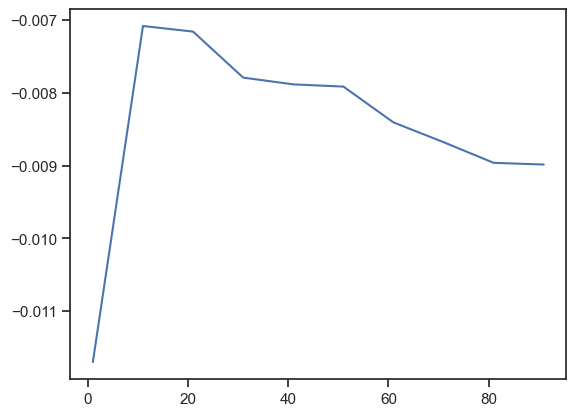

In [35]:
# Изменение качества на тестовой выборке в зависимости от К-соседей
plt.plot(n_range, regr_gs.cv_results_['mean_test_score'])

### Построение моделей с учетом подбора гиперпараметра. Сравнение качества полученных моделей с качеством baseline-моделей.

In [36]:
regr_models_grid = {'KNN_5':KNeighborsRegressor(n_neighbors=5), 
                    str('KNN_'+regr_gs_best_params_txt):regr_gs.best_estimator_}

In [37]:
for model_name, model in regr_models_grid.items():
    regr_train_model(model_name, model, regrMetricLogger)

KNN_5 	 MAE=0.067, MSE=0.009, R2=0.621
KNN_11 	 MAE=0.065, MSE=0.009, R2=0.62


### Формирование выводов о качестве построенных моделей на основе выбранных метрик. Результаты сравнения качества рекомендуется отобразить в виде графиков и сделать выводы в форме текстового описания. Рекомендуется построение графиков обучения и валидации, влияния значений гиперпарметров на качество моделей и т.д.

In [38]:
# Метрики качества модели
regr_metrics = regrMetricLogger['MetricName'].unique()
regr_metrics

array(['MAE', 'MSE', 'R2'], dtype=object)

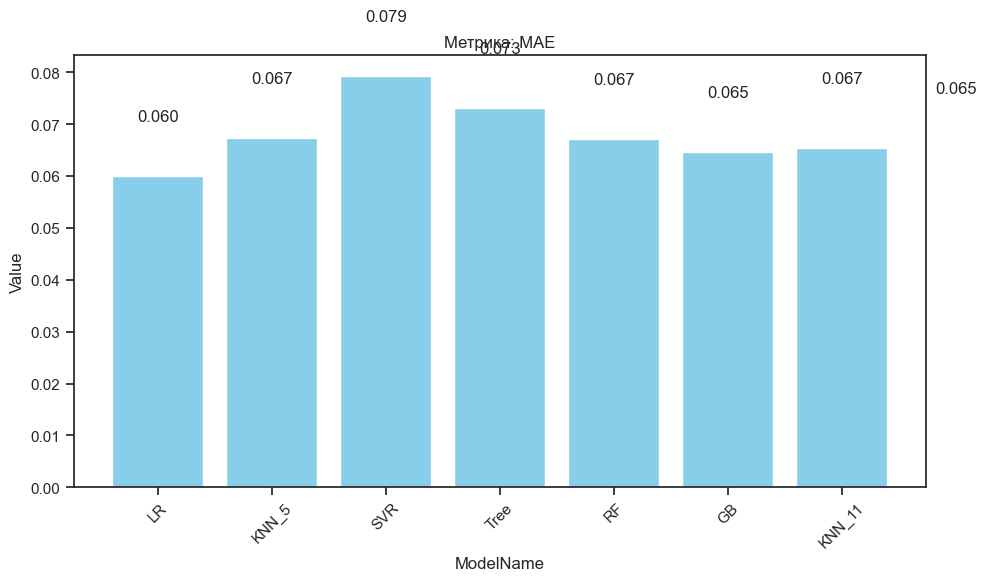

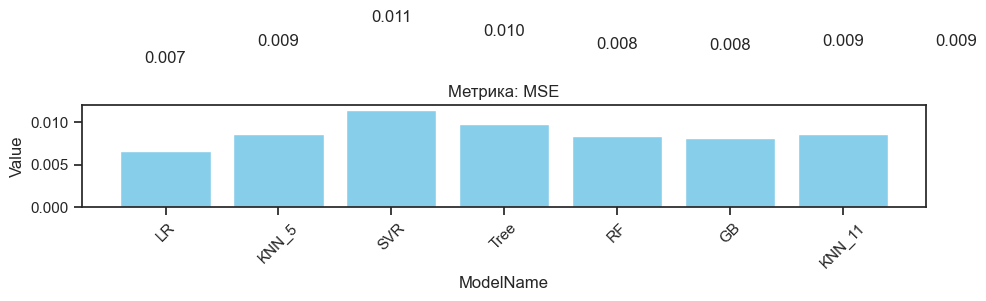

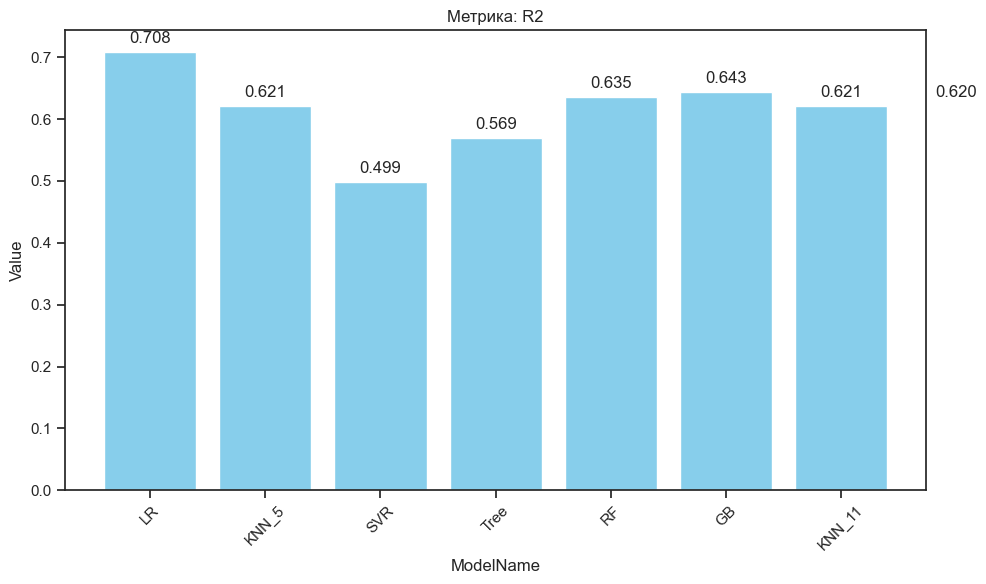

In [39]:
import matplotlib.pyplot as plt

def plot_metric(regrMetricLogger, metric_name):
    # Фильтрация DataFrame для отображения только интересующей метрики
    filtered_df = regrMetricLogger[regrMetricLogger['MetricName'] == metric_name][['ModelName', 'Value']]
    
    # Создание столбчатой диаграммы
    plt.figure(figsize=(10, 6))
    plt.bar(filtered_df['ModelName'], filtered_df['Value'], color='skyblue')
    
    # Добавление подписей к столбцам
    for i, value in enumerate(filtered_df['Value']):
        plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')
    
    plt.xlabel('ModelName')
    plt.ylabel('Value')
    plt.title(f'Метрика: {metric_name}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Пример использования функции для каждой из метрик
metrics = ['MAE', 'MSE', 'R2']
for metric in metrics:
    plot_metric(regrMetricLogger, metric)


**Лучше всего себя показала линейная регресия**